In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from functools import partial

In [3]:
df = pd.read_json("../reports/ae_test_v4.jsonl", orient='records', lines=True)
df['anom_scores'] = df['anom_scores'].apply(np.array)
df['is_anom'] = df['is_anom'].apply(np.array)
df['roc_auc'] = df.apply(lambda row: roc_auc_score(row['is_anom'], row['anom_scores']), axis=1)
df['mean_anom_score'] = df['anom_scores'].apply(np.mean)


In [4]:
dfm = df.groupby(['dataset', 'mode', 'p_anomaly'])[['mean_anom_score', 'roc_auc']].mean()
dfm

mean_anom_score   roc_auc
dataset        mode               p_anomaly                           
Covertype      online             0.02              0.031723  0.840322
                                  0.04              0.026883  0.765805
                                  0.08              0.030278  0.681473
               pre-trained        0.02              0.036426  0.996689
                                  0.04              0.036939  0.996689
                                  0.08              0.037957  0.996670
               pre-trained+online 0.02              0.021255  0.989516
                                  0.04              0.021603  0.989233
                                  0.08              0.022084  0.981002
Insects abrupt online             0.02              0.037918  0.616148
                                  0.04              0.050528  0.585350
                                  0.08              0.045585  0.584196
               pre-trained        0.02              0.045582  0.525406
                                  0.04              0.045615  0.526739
                                  0.08              0.045659  0.523038
               pre-trained+online 0.02              0.035788  0.579136
                                  0.04              0.035511  0.580571
                                  0.08              0.036474  0.565845
Rotated MNIST  online             0.02              0.077500  0.586398
                                  0.04              0.078342  0.568822
                                  0.08              0.076807  0.548293
               pre-trained        0.02              0.092306  0.462301
                                  0.04              0.092229  0.460139
                                  0.08              0.092099  0.462253
               pre-trained+online 0.02              0.057620  0.640126
                                  0.04              0.057567  0.616732
                                  0.08              0.057428  0.580083

In [5]:
def tumbling_roc_auc_score(row, window_size=1000):
    is_anom = row["is_anom"]
    anom_score = row["anom_scores"]
    return [
        roc_auc_score(
            is_anom[start : start + window_size],
            anom_score[start : start + window_size],
        )
        for start in range(0, len(anom_score) - window_size, window_size)
    ]


def tumbling_rec_error(row, window_size=1000):
    anom_score = row["anom_scores"]
    return [
        anom_score[start : start + window_size].mean()
        for start in range(0, len(anom_score) - window_size, window_size)
    ]


/tmp/ipykernel_101439/4137218811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['tumbling_rec_error'] = df_plot.apply(tumbling_rec_error, axis=1)


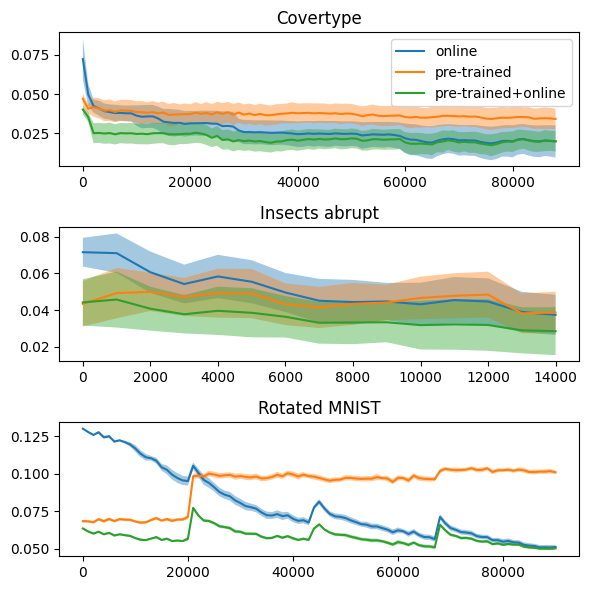

In [6]:
# Plot reconstruction error vs. time
df_plot = df[df['p_anomaly'] == .04]
df_plot['tumbling_rec_error'] = df_plot.apply(tumbling_rec_error, axis=1)
fig, axs = plt.subplots(nrows=3, figsize=(6, 6))
y_metric = 'tumbling_rec_error'

for ax, (dataset, dfg) in zip(axs, df_plot.groupby(["dataset"])):
    for mode, dfo in dfg.groupby("mode"):
        roc_scores = dfo[y_metric].to_list()
        min_len = min([len(roc_score) for roc_score in roc_scores])
        score_array = np.array([score[:min_len] for score in roc_scores])
        mean_scores = score_array.mean(axis=0)
        std_scores = score_array.std(axis=0)
        x = np.arange(0, len(mean_scores)) * 1000
        ax.plot(x, mean_scores, label=mode)
        ax.fill_between(x, mean_scores-std_scores, mean_scores+std_scores, alpha=.4)
        ax.set_title(dataset[0])
        


axs[0].legend()
fig.tight_layout()

/tmp/ipykernel_101439/1224982752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['tumbling_roc_auc'] = df_plot.apply(tumbling_roc_auc_score, axis=1)


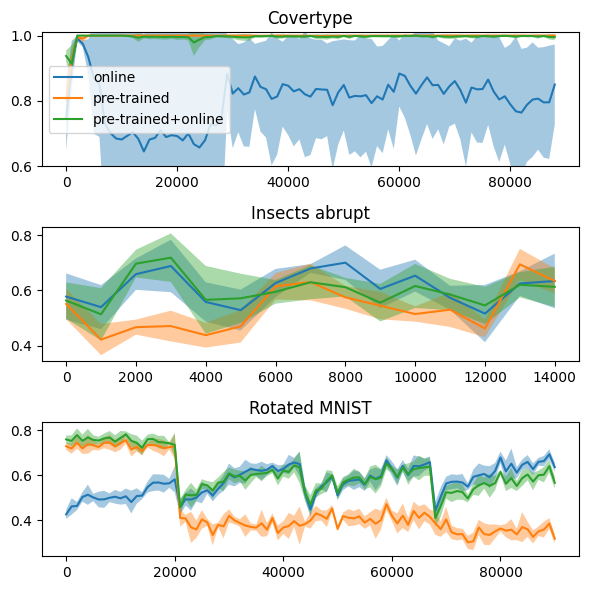

In [58]:
# Plot reconstruction error vs. time
df_plot = df[df['p_anomaly'] == .04]
df_plot['tumbling_roc_auc'] = df_plot.apply(tumbling_roc_auc_score, axis=1)
fig, axs = plt.subplots(nrows=3, figsize=(6, 6))
y_metric = 'tumbling_roc_auc'

for ax, (dataset, dfg) in zip(axs, df_plot.groupby(["dataset"])):
    for mode, dfo in dfg.groupby("mode"):
        roc_scores = dfo[y_metric].to_list()
        min_len = min([len(roc_score) for roc_score in roc_scores])
        score_array = np.array([score[:min_len] for score in roc_scores])
        mean_scores = score_array.mean(axis=0)
        std_scores = score_array.std(axis=0)
        x = np.arange(0, len(mean_scores)) * 1000
        ax.plot(x, mean_scores, label=mode)
        ax.fill_between(x, mean_scores-std_scores, mean_scores+std_scores, alpha=.4)
        ax.set_title(dataset[0])
        
axs[0].legend()
axs[0].set_ylim(0.6, 1.01)
fig.tight_layout()

In [49]:
def get_f1_score(row, quantile, window_size=1000):
    is_anom = row["is_anom"]
    anom_score = row["anom_scores"]
    threshold = (
        pd.Series(anom_score).rolling(window_size, min_periods=1).quantile(quantile)
    )
    anom_pred = anom_score > threshold
    return f1_score(is_anom, anom_pred)


def get_fixed_thresh_f1_score(row, quantile, window_size=1000):
    is_anom = row["is_anom"]
    anom_score = row["anom_scores"]
    threshold = pd.Series(anom_score).expanding(min_periods=1).quantile(quantile)
    anom_pred = anom_score > threshold
    return f1_score(is_anom, anom_pred)


def get_scaled_roc_auc(row, window_size=1000):
    is_anom = row["is_anom"]
    anom_score = row["anom_scores"]
    rolling_mean = pd.Series(anom_score).rolling(window_size, min_periods=1).mean()
    scaled_anom_score = anom_score / rolling_mean
    threshold = pd.Series(scaled_anom_score).expanding(min_periods=1).quantile(0.96)

    return f1_score(is_anom, scaled_anom_score > threshold)

In [50]:
quantiles = [0.9, 0.92, 0.94, 0.96, 0.98]
for quantile in quantiles:
    df[f"f1_{quantile}"] = df.apply(partial(get_f1_score, quantile=quantile), axis=1)

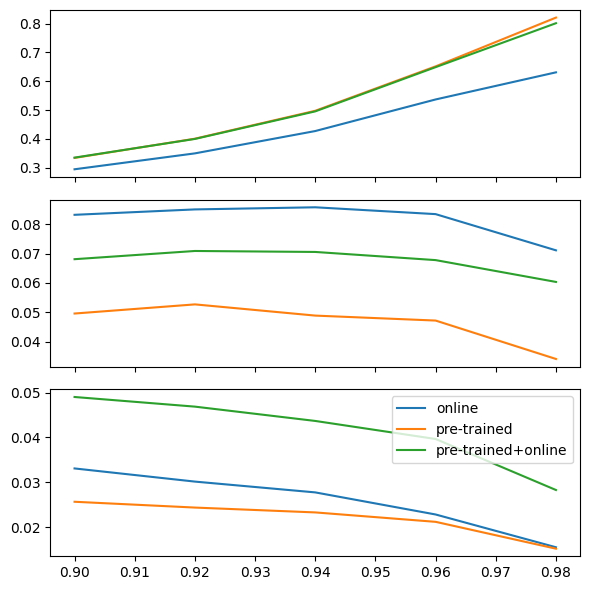

In [26]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 6), sharex=True)
df_plot = df[df['p_anomaly'] ==0.02]

for ax, (dataset, dfd) in zip(axs, df_plot.groupby("dataset")):
    for mode, dfmode in dfd.groupby("mode"):
        mean_f1_scores = [dfmode[f"f1_{quantile}"].mean() for quantile in quantiles]
        ax.plot(quantiles, mean_f1_scores, label=mode)

ax.legend()
fig.tight_layout()

In [59]:
df4 = df[df["p_anomaly"] == 0.04]
window_sizes = [200, 400, 600, 800, 1000, 1200]
df4["f1@fixed"] = df4.apply(partial(get_f1_score, quantile=0.96), axis=1)

for window_size in window_sizes:
    df4[f"f1@{window_size}"] = df4.apply(
        partial(get_f1_score, window_size=window_size, quantile=0.96), axis=1
    )

/tmp/ipykernel_101439/3095150191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["f1@fixed"] = df4.apply(partial(get_f1_score, quantile=0.96), axis=1)
/tmp/ipykernel_101439/3095150191.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4[f"f1@{window_size}"] = df4.apply(
/tmp/ipykernel_101439/3095150191.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

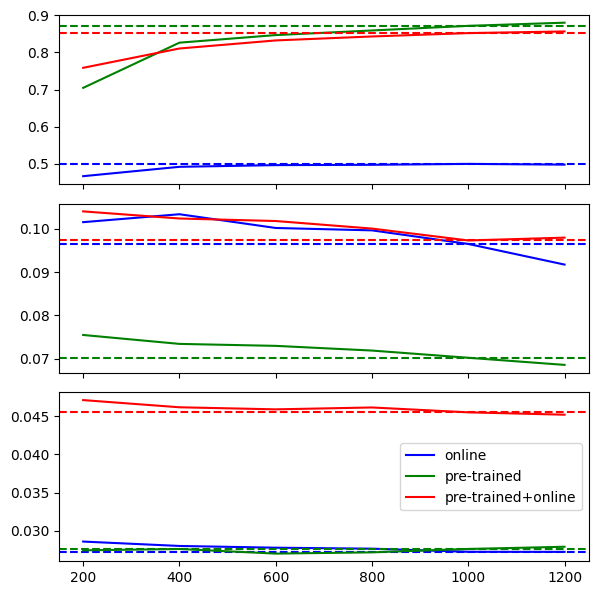

In [60]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 6), sharex=True)
colors = {"pre-trained": "g", "online": "b", "pre-trained+online": "r"}

for ax, (dataset, dfd) in zip(axs, df4.groupby("dataset")):
    for mode, dfmode in dfd.groupby("mode"):
        color = colors[mode]
        mean_f1_scores = [
            dfmode[f"f1@{window_size}"].mean() for window_size in window_sizes
        ]
        ax.plot(window_sizes, mean_f1_scores, label=mode, color=color)
        ax.axhline(y=dfmode["f1@fixed"].mean(), linestyle="--", color=color)

# ax.set_xscale("log")
ax.legend()
fig.tight_layout()

In [46]:
df4 = df[df["p_anomaly"] == 0.04]
window_sizes = [200, 400, 600, 800, 1000]

for window_size in window_sizes:
    df4[f"roc@{window_size}"] = df4.apply(
        partial(get_scaled_roc_auc, window_size=window_size), axis=1
    )

/tmp/ipykernel_101439/4010101754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4[f"roc@{window_size}"] = df4.apply(
/tmp/ipykernel_101439/4010101754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4[f"roc@{window_size}"] = df4.apply(
/tmp/ipykernel_101439/4010101754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

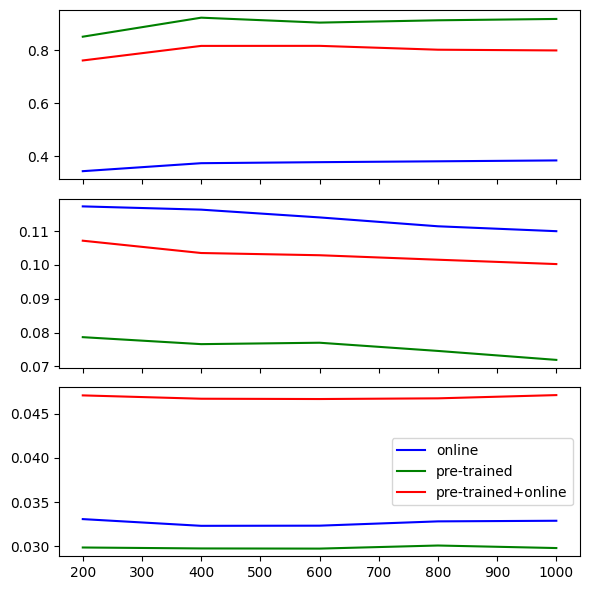

In [48]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 6), sharex=True)
colors = {"pre-trained": "g", "online": "b", "pre-trained+online": "r"}

for ax, (dataset, dfd) in zip(axs, df4.groupby("dataset")):
    for mode, dfmode in dfd.groupby("mode"):
        color = colors[mode]
        mean_f1_scores = [
            dfmode[f"roc@{window_size}"].mean() for window_size in window_sizes
        ]
        ax.plot(window_sizes, mean_f1_scores, label=mode, color=color)
        # ax.axhline(y=dfmode["roc_auc"].mean(), linestyle="--", color=color)

# ax.set_xscale("log")
ax.legend()
fig.tight_layout()